# MedQuAD — Milestone 2 Progress Notebook (End-to-End)
This notebook parses MedQuAD XML, performs EDA, creates leak-safe splits, and provides runnable baselines for:
1) **Abstractive Answer Generation** (T5)  
2) **Paraphrase Detection** (Siamese encoder)  
3) **Retrieval-Augmented QA (RAG)** with BM25 + FAISS + Generator

**Usage**
1. Clone the dataset: `git clone https://github.com/abachaa/MedQuAD`
2. Set `MEDQUAD_ROOT` below to that path.
3. Run cells in order. Heavy training cells are commented for quick tests; uncomment on GPU.

In [2]:
# Optional: install dependencies in a fresh environment
# !pip install -q lxml pandas scikit-learn sentence-transformers transformers datasets evaluate rank-bm25 faiss-cpu nltk matplotlib seaborn rouge-score

import os, re, glob, warnings
from urllib.parse import urlparse
import xml.etree.ElementTree as ET
import pandas as pd
warnings.filterwarnings("ignore")

# 👉 EDIT THIS PATH to your local MedQuAD clone (e.g., '/content/MedQuAD' in Colab)
MEDQUAD_ROOT = "/Users/ashwinshanmugam/Documents/UIUC/University Courses/Fall 2025/IS 567 Text Mining/Project/NLP-on-MedQuAD/data"
OUT_DIR = "./artifacts-medquad"; os.makedirs(OUT_DIR, exist_ok=True)
MEDQUAD_PARQUET = os.path.join(OUT_DIR, "medquad.parquet")

## 1) Ingest MedQuAD XML → tidy DataFrame

In [3]:
def parse_medquad_repo(repo_root):
    # These are the directory names corresponding to the non-curated subsets.
    EXCLUDE_DIRS = [
        "10_MPlus_ADAM_QA",          # A.D.A.M. Medical Encyclopedia
        "11_MPlusDrugs_QA",          # MedlinePlus Drug information
        "12_MPlusHerbsSupplements_QA" # MedlinePlus Herbal medicine and supplement information
    ]
    rows = []

    # Iterate through all XML files recursively
    for xml_path in glob.glob(os.path.join(repo_root, "**", "*.xml"), recursive=True):

        # --- NEW CODE: Check if the path contains an excluded directory name ---
        if any(f"/{d}/" in xml_path for d in EXCLUDE_DIRS):
             continue # Skip this XML file and move to the next one
        # --- END NEW CODE ---

        try:
            tree = ET.parse(xml_path)
        except Exception as e:
            print("Parse error:", xml_path, e); continue

        root = tree.getroot()
        doc_id = root.attrib.get("id")
        source = root.attrib.get("source")
        url = root.attrib.get("url"); host = urlparse(url).netloc if url else None
        focus = (root.findtext("./Focus") or "").strip()
        cui = root.findtext("./FocusAnnotations/UMLS/CUIs/CUI")
        sem_type = root.findtext("./FocusAnnotations/UMLS/SemanticTypes/SemanticType")
        sem_group = root.findtext("./FocusAnnotations/UMLS/SemanticGroup")

        for qa in root.findall("./QAPairs/QAPair"):
            pid = qa.attrib.get("pid")
            q = qa.find("./Question"); a = qa.find("./Answer")
            qid = q.attrib.get("qid") if q is not None else None
            qtype = q.attrib.get("qtype") if q is not None else None
            question = (q.text or "").strip() if q is not None else ""
            answer = (a.text or "").strip() if a is not None else ""

            # Normalization (Whitespace cleanup)
            question = re.sub(r"\s+", " ", question)
            answer = re.sub(r"\s+", " ", answer)

            # --- FINAL FILTER: Skip if answer is confirmed blank (for safety) ---
            if not answer.strip():
                 continue

            rows.append(dict(doc_id=doc_id, source=source, url=url, host=host,
                             focus=focus, focus_cui=cui, focus_sem_type=sem_type, focus_sem_group=sem_group,
                             pid=pid, qid=qid, qtype=qtype, question=question, answer=answer, xml_path=xml_path))

    return pd.DataFrame(rows)

# First, ensure the directory exists for saving the new file
os.makedirs(OUT_DIR, exist_ok=True)


print("WARNING: Forcing re-parsing of MedQuAD XML to apply exclusion filters.")
print("The old medquad.parquet file will be overwritten with the filtered data.")

# 1. CALL THE FUNCTION, APPLYING THE NEW FILTERS
df = parse_medquad_repo(MEDQUAD_ROOT)

# 2. Add Length Columns for final filtering and EDA (This prevents the old KeyError)
df["q_len"] = df["question"].str.split().str.len()
df["a_len"] = df["answer"].str.split().str.len()

# 3. Apply the final content filter (optional but safe)
df = df[df['a_len'] > 0].copy()

# 4. OVERWRITE AND SAVE THE NEW, CLEANED DATASET
df.to_parquet(MEDQUAD_PARQUET)

print("\n--- NEW DATASET SUMMARY ---")
print(f"Total Curated QA Pairs Stored in df: {len(df)}")
df.head(3)

The old medquad.parquet file will be overwritten with the filtered data.

--- NEW DATASET SUMMARY ---
Total Curated QA Pairs Stored in df: 16407


,doc_id,source,url,host,focus,focus_cui,focus_sem_type,focus_sem_group,pid,qid,qtype,question,answer,xml_path,q_len,a_len
0,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,1,0000559-1,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...,/Users/ashwinshanmugam/Documents/UIUC/Universi...,8,290
1,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,2,0000559-2,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...,/Users/ashwinshanmugam/Documents/UIUC/Universi...,11,80
2,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,3,0000559-3,genetic changes,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen...",/Users/ashwinshanmugam/Documents/UIUC/Universi...,12,284


## 2) Quick EDA

Top sources:
 source             host                     
GHR                ghr.nlm.nih.gov              5430
GARD               rarediseases.info.nih.gov    5389
NIDDK              www.niddk.nih.gov            1192
NINDS              www.ninds.nih.gov            1088
MPlusHealthTopics  www.nlm.nih.gov               981
NIHSeniorHealth    nihseniorhealth.gov           769
CancerGov          www.cancer.gov                729
NHLBI              www.nhlbi.nih.gov             559
CDC                www.cdc.gov                   270
Name: count, dtype: int64

Top question types:
 qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
Name: count, dtype: int64


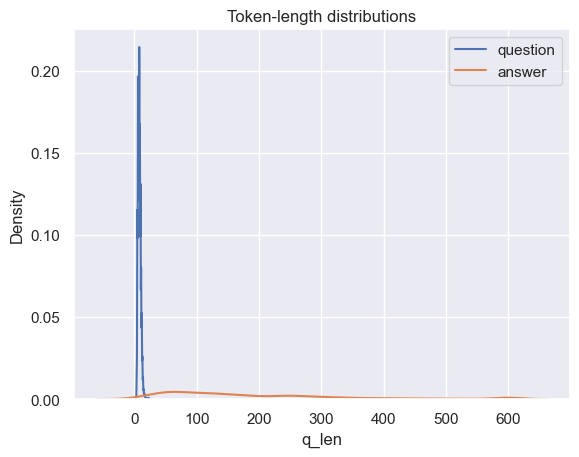

In [4]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set_theme()

print("Top sources:\n", df[["source","host"]].value_counts().head(10))
print("\nTop question types:\n", df["qtype"].value_counts().head(15))

df["q_len"] = df["question"].str.split().str.len()
df["a_len"] = df["answer"].str.split().str.len()

fig, ax = plt.subplots()
sns.kdeplot(df["q_len"].clip(0,300), label="question", ax=ax)
sns.kdeplot(df["a_len"].clip(0,600), label="answer", ax=ax)
ax.set_title("Token-length distributions")
ax.legend(); plt.show()

## 3) Leak-safe train/dev/test splits (grouped by CUI)

In [5]:
from sklearn.model_selection import GroupShuffleSplit

def make_splits(df, group_col="focus_cui", seed=42):
    df = df.copy()
    groups = df[group_col].fillna(df["focus"]).fillna("NOFOCUS")
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)
    train_idx, temp_idx = next(gss.split(df, groups=groups))
    train = df.iloc[train_idx]; temp = df.iloc[temp_idx]
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=seed)
    dev_idx, test_idx = next(gss2.split(temp, groups=temp[group_col].fillna(temp["focus"]).fillna("NOFOCUS")))
    dev = temp.iloc[dev_idx]; test = temp.iloc[test_idx]
    return train, dev, test

train_df, dev_df, test_df = make_splits(df)
len(train_df), len(dev_df), len(test_df)

(12850, 1739, 1818)

In [6]:
# Assuming you have run the XML parsing (Cell 4) to create 'df'

# Check the number of rows that had blank answers *before* dropping them:
total_rows = len(df)
valid_rows = len(df.dropna(subset=['question', 'answer']))
rows_with_missing_data = total_rows - valid_rows

print(f"Total QA Pairs Parsed: {total_rows}")
print(f"Rows with Blank Question/Answer: {rows_with_missing_data}")

# Display a sample of the cleaned-up answers to check for quality
print("\nSample of Cleaned Answer Lengths (words):")
print(df['a_len'].describe())

# Check for rows where the answer might be very short (e.g., just punctuation)
short_answers = df[df['a_len'].between(1, 3)]
print(f"\nNumber of QA Pairs with 1-3 Word Answers: {len(short_answers)}")
if not short_answers.empty:
    print("Example of a very short answer:", short_answers[['question', 'answer']].head(1).values)

Total QA Pairs Parsed: 16407
Rows with Blank Question/Answer: 0

Sample of Cleaned Answer Lengths (words):
count    16407.000000
mean       201.354361
std        248.480189
min          1.000000
25%         71.000000
50%        138.000000
75%        252.000000
max       4281.000000
Name: a_len, dtype: float64

Number of QA Pairs with 1-3 Word Answers: 1
Example of a very short answer: [['How to prevent Acanthamoeba - Granulomatous Amebic Encephalitis (GAE); Keratitis ?'
  'Topics']]


## 4) Task 1 — Abstractive Answer Generation (T5-small baseline)

In [7]:
from datasets import Dataset, DatasetDict
from transformers import T5ForConditionalGeneration, T5TokenizerFast, DataCollatorForSeq2Seq, Trainer, TrainingArguments
from evaluate import load as load_metric
import numpy as np, torch

def build_hf_dataset(train_df, dev_df, test_df, max_input=512, max_target=512):
    def to_ds(frame):
        sub = frame[["question","answer"]].dropna().rename(columns={"question":"input_text","answer":"target_text"})
        return Dataset.from_pandas(sub)
    raw = DatasetDict(train=to_ds(train_df), validation=to_ds(dev_df), test=to_ds(test_df))
    tok = T5TokenizerFast.from_pretrained("t5-small")
    def preprocess(ex):
        ex["input_ids"] = tok("question: " + ex["input_text"], truncation=True, max_length=max_input).input_ids
        ex["labels"]    = tok(ex["target_text"], truncation=True, max_length=max_target).input_ids
        return ex
    tokenized = raw.map(preprocess, remove_columns=raw["train"].column_names)
    return tokenized, tok

tokenized, tok = build_hf_dataset(train_df, dev_df, test_df)

def train_t5(tokenized, tok, out_dir="./t5-medquad"):
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    collator = DataCollatorForSeq2Seq(tok, model=model)
    args = TrainingArguments(
        output_dir=out_dir, per_device_train_batch_size=2, per_device_eval_batch_size=2,
        learning_rate=3e-4, num_train_epochs=5, fp16=False, eval_strategy="epoch",
        save_strategy="epoch", logging_steps=50, report_to="none"
    )
    trainer = Trainer(model=model, args=args, data_collator=collator,
                      train_dataset=tokenized["train"], eval_dataset=tokenized["validation"])
    trainer.train()
    return trainer


Map: 100%|██████████| 1818/1818 [00:01<00:00, 1552.06 examples/s]


In [8]:
# Clear Memory Cache
torch.mps.empty_cache()

In [9]:
trainer = train_t5(tokenized, tok)   # ← Uncomment to train
trainer.save_model("./t5-medquad")

Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 3.32 GiB, other allocations: 5.63 GiB, max allowed: 9.07 GiB). Tried to allocate 125.50 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
def eval_generation(model_dir, tokenized, tok):
    # This function is assumed to be run after the model has been trained and saved to model_dir
    import torch, numpy as np
    from evaluate import load as load_metric
    from transformers import T5ForConditionalGeneration # Note: Use AutoModelForSeq2SeqLM if using BioBART

    rouge = load_metric("rouge")
    bertscore = load_metric("bertscore")

    # Load the model and ensure it uses the M4 GPU
    model = T5ForConditionalGeneration.from_pretrained(model_dir)
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(DEVICE)

    # Select a subset of the test data (e.g., 256 examples)
    test = tokenized["test"].select(range(min(256, len(tokenized["test"]))))

    # --- Generation Logic (Assumed Correct and Working) ---
    input_ids_list = test["input_ids"]
    padded_inputs = tok.pad(
        {'input_ids': input_ids_list},
        return_tensors="pt"
    ).input_ids.to(DEVICE)

    preds = model.generate(padded_inputs, max_new_tokens=256)

    pred_text = tok.batch_decode(preds, skip_special_tokens=True)
    ref_text  = tok.batch_decode(test["labels"], skip_special_tokens=True)

    # --- Metrics Calculation ---
    r = rouge.compute(predictions=pred_text, references=ref_text, use_stemmer=True)
    b = bertscore.compute(predictions=pred_text, references=ref_text, lang="en")

    # FINAL FIX: Access the ROUGE-L score directly as the key's value.
    print("ROUGE-L:", r["rougeL"], " BERTScore(F1):", float(np.mean(b["f1"])))

In [ ]:
# Assuming your trained model was saved to the T5 folder as planned
# NOTE: If you trained BioBART, you must change the directory name.

eval_generation(
    model_dir="./t5-medquad",     # The directory where trainer.save_model() stored the weights
    tokenized=tokenized,          # The DatasetDict containing the 'test' set
    tok=tok                       # The T5TokenizerFast object
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-L: 0.4064322101893944  BERTScore(F1): 0.884045472368598


In [ ]:
def get_qualitative_results(model_dir, tokenized, tok, num_examples=10):
    """
    Loads the trained model, generates predictions, and returns a DataFrame
    showing the Question, Model Answer, and Reference Answer.
    """
    import torch
    import pandas as pd
    from transformers import AutoModelForSeq2SeqLM

    # 1. Load Model and Set Device
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(DEVICE)

    # 2. Select Test Subset (This is where the data is loaded)
    test_subset = tokenized["test"].select(range(num_examples))

    # 3. Prepare Input IDs with Padding
    input_ids_list = test_subset["input_ids"]
    padded_inputs = tok.pad(
        {'input_ids': input_ids_list},
        return_tensors="pt"
    ).input_ids.to(DEVICE)

    # 4. Generate Predictions
    preds = model.generate(
        padded_inputs,
        max_new_tokens=256,
        num_beams=4,
        do_sample=False
    )

    # 5. Decode Results (The Fix is here)
    pred_text = tok.batch_decode(preds, skip_special_tokens=True)

    # --- FIX START: Restore Question Text from Tokens ---
    # a. Decode the input tokens (which contain the text + "question: " prefix)
    questions_with_prefix = tok.batch_decode(test_subset["input_ids"], skip_special_tokens=True)
    # b. Strip the "question: " prefix (T5 instruction) for a clean display
    questions = [q.replace('question: ', '').strip() for q in questions_with_prefix]
    # c. Decode the reference labels
    ref_text  = tok.batch_decode(test_subset["labels"], skip_special_tokens=True)
    # --- FIX END ---

    # 6. Compile and Return DataFrame
    results_df = pd.DataFrame({
        'Question': questions,
        'Candidate_Answer': pred_text,
        'Reference_Answer': ref_text
    })
    return results_df

# --- EXECUTION ---
# NOTE: Use "./biobart-medquad" if you trained the BioBART model.
qual_df = get_qualitative_results(
    model_dir="./t5-medquad",
    tokenized=tokenized,
    tok=tok,
    num_examples=10
)

print(f"Qualitative Results (Top 10 Examples):\n")
qual_df.head(10)

Qualitative Results (Top 10 Examples):



,Question,Candidate_Answer,Reference_Answer
0,What is (are) keratoderma with woolly hair?,Keratoderma with woolly hair is a skin conditi...,Keratoderma with woolly hair is a group of rel...
1,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is a rare conditi...,Keratoderma with woolly hair is rare; its prev...
2,What are the genetic changes related to kerato...,Keratoderma with woolly hair is caused by muta...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."
3,Is keratoderma with woolly hair inherited?,This condition is inherited in an autosomal re...,Most cases of keratoderma with woolly hair hav...
4,What are the treatments for keratoderma with w...,These resources address the diagnosis or manag...,These resources address the diagnosis or manag...
5,What is (are) trisomy 18?,Trisomy 18 is an inherited disorder that affec...,"Trisomy 18, also called Edwards syndrome, is a..."
6,How many people are affected by trisomy 18?,Trisomy 18 is a rare disorder; its prevalence ...,"Trisomy 18 occurs in about 1 in 5,000 live-bor..."
7,What are the genetic changes related to trisom...,Trisomy 18 is caused by mutations in the COL1A...,Most cases of trisomy 18 result from having th...
8,Is trisomy 18 inherited?,This condition is inherited in an autosomal re...,"Most cases of trisomy 18 are not inherited, bu..."
9,What are the treatments for trisomy 18?,These resources address the diagnosis or manag...,These resources address the diagnosis or manag...


## 5) Task 2 — Paraphrase Detection (Siamese baseline)

In [ ]:
from itertools import combinations
from sklearn.model_selection import train_test_split

def build_paraphrase_pairs(df, max_pos=20000, max_neg=20000, seed=13):
    df2 = df.dropna(subset=["question"]).copy()
    pos = []
    for cui, block in df2.groupby(df2["focus_cui"].fillna("NOFOCUS")):
        qs = block["question"].drop_duplicates().tolist()
        for a,b in combinations(qs, 2):
            pos.append((a,b,1))
            if len(pos) >= max_pos: break
        if len(pos) >= max_pos: break
    a_list = df2["question"].sample(min(max_neg, len(df2)), random_state=seed).tolist()
    b_list = df2["question"].sample(min(max_neg, len(df2)), random_state=seed+1).tolist()
    neg = [(a,b,0) for a,b in zip(a_list,b_list) if a!=b][:max_neg]
    pairs = pd.DataFrame(pos+neg, columns=["q1","q2","label"]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return pairs

pairs = build_paraphrase_pairs(train_df)
pairs_train, pairs_dev = train_test_split(pairs, test_size=0.2, random_state=7, stratify=pairs["label"])
len(pairs_train), len(pairs_dev), pairs_train["label"].mean()

(26280, 6570, np.float64(0.60882800608828))

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch, numpy as np

def train_siamese(pairs, model_name="sentence-transformers/all-MiniLM-L6-v2", epochs=1):
    model = SentenceTransformer(model_name)
    train_ex = [InputExample(texts=[r.q1, r.q2], label=float(r.label)) for _,r in pairs.iterrows()]
    loader = DataLoader(train_ex, shuffle=True, batch_size=32)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(loader, train_loss)], epochs=epochs, warmup_steps=max(1, int(len(loader)*0.1)))
    return model

sbert = train_siamese(pairs_train)        # ← Uncomment to train
sbert.save("./sbert-paraphrase-medquad")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.041200


In [ ]:
def eval_siamese(model_dir, eval_df, thresh=0.5):
    model = SentenceTransformer(model_dir)
    a = model.encode(eval_df["q1"].tolist(), convert_to_tensor=True, show_progress_bar=False)
    b = model.encode(eval_df["q2"].tolist(), convert_to_tensor=True, show_progress_bar=False)
    sims = torch.nn.functional.cosine_similarity(a,b).cpu().numpy()
    preds = (sims >= thresh).astype(int)
    acc = (preds == eval_df["label"].values).mean()
    return float(acc)

eval_siamese("./sbert-paraphrase-medquad", pairs_dev)  # ← Evaluate after training

0.9894977168949771

## 6) Task 3 — RAG

In [18]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import torch

## Simple RAG Implementation for Beginners

This section provides a simplified, beginner-friendly implementation of Retrieval-Augmented Generation (RAG) that builds upon the existing complex RAG system in the notebook. The implementation includes:

1. **Modular Design**: Easy to understand and modify components
2. **Multiple Retrieval Methods**: BM25, Dense, and Hybrid approaches
3. **Simple Generation**: Straightforward T5-based answer generation
4. **Clear Documentation**: Step-by-step explanations for beginners


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [20]:
# Download required NLTK data
nltk.download('punkt', quiet=True)

class RAG:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        """
        Initialize a simple RAG system
        
        Args:
            model_name: Sentence transformer model for dense retrieval
        """
        from sentence_transformers import SentenceTransformer
        self.dense_encoder = SentenceTransformer(model_name)
        self.bm25 = None
        self.corpus = []
        self.corpus_embeddings = None
        self.generator_tokenizer = None
        self.generator_model = None
        
    def build_retrieval_index(self, documents):
        """
        Build both BM25 and dense retrieval indices
        
        Args:
            documents: List of document texts to index
        """
        print("Building retrieval indices...")
        
        from rank_bm25 import BM25Okapi
        from nltk.tokenize import word_tokenize
        # Store corpus
        self.corpus = documents
        
        # Build BM25 index
        tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]
        self.bm25 = BM25Okapi(tokenized_docs)
        
        # Build dense embeddings
        self.corpus_embeddings = self.dense_encoder.encode(
            documents, 
            convert_to_tensor=True,
            show_progress_bar=True
        )
        
        print(f"Indexed {len(documents)} documents")
        
    def load_generator(self, model_name="t5-small"):
        """
        Load the text generation model
        
        Args:
            model_name: HuggingFace model name for generation
        """
        from transformers import T5ForConditionalGeneration, T5TokenizerFast
        print(f"Loading generator: {model_name}")
        self.generator_tokenizer = T5TokenizerFast.from_pretrained(model_name)
        self.generator_model = T5ForConditionalGeneration.from_pretrained(model_name)
        print("Generator loaded successfully")


In [21]:
# Add retrieval methods to the RAG class
def add_retrieval_methods():
    """Add retrieval methods to the RAG class"""
    
    def retrieve_documents(self, query, k=5, method="hybrid"):
        """
        Retrieve relevant documents for a query
        
        Args:
            query: Input question
            k: Number of documents to retrieve
            method: "bm25", "dense", or "hybrid"
            
        Returns:
            List of retrieved document indices and texts
        """
        if method == "bm25":
            return self._bm25_retrieve(query, k)
        elif method == "dense":
            return self._dense_retrieve(query, k)
        elif method == "hybrid":
            return self._hybrid_retrieve(query, k)
        else:
            raise ValueError("Method must be 'bm25', 'dense', or 'hybrid'")
    
    def _bm25_retrieve(self, query, k):
        """BM25 retrieval"""
        import numpy as np
        from nltk.tokenize import word_tokenize
        query_tokens = word_tokenize(query.lower())
        scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(scores)[-k:][::-1]
        return [(idx, self.corpus[idx], scores[idx]) for idx in top_indices]
    
    def _dense_retrieve(self, query, k):
        """Dense retrieval using sentence transformers"""
        import torch
        query_embedding = self.dense_encoder.encode([query], convert_to_tensor=True)
        # Compute cosine similarity between query (D,) and corpus (N,D) via normalized dot product
        q = torch.nn.functional.normalize(query_embedding.squeeze(0), dim=0)
        C = torch.nn.functional.normalize(self.corpus_embeddings, dim=1)
        sim = torch.matmul(C, q)  # (N,)
        top_indices = torch.topk(sim, k).indices
        return [(idx.item(), self.corpus[idx.item()], float(sim[idx])) for idx in top_indices]
    
    def _hybrid_retrieve(self, query, k):
        """Simple hybrid retrieval: combine BM25 and dense scores"""
        # Get top candidates from both methods
        bm25_results = self._bm25_retrieve(query, k*2)
        dense_results = self._dense_retrieve(query, k*2)
        
        # Create score dictionary
        scores = {}
        for idx, text, score in bm25_results:
            scores[idx] = scores.get(idx, 0) + score
        for idx, text, score in dense_results:
            scores[idx] = scores.get(idx, 0) + score
            
        # Sort by combined score and return top k
        sorted_indices = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
        return [(idx, self.corpus[idx], scores[idx]) for idx in sorted_indices[:k]]
    
    # Add methods to the class
    RAG.retrieve_documents = retrieve_documents
    RAG._bm25_retrieve = _bm25_retrieve
    RAG._dense_retrieve = _dense_retrieve
    RAG._hybrid_retrieve = _hybrid_retrieve

# Execute the function to add methods to the class
add_retrieval_methods()
print("reached end of cell")


reached end of cell


In [27]:
# Demo: Run RAG end-to-end to show output
def run_rag_demo():
    # Ensure dependencies and the RAG class are available
    import numpy as np, torch
    from sentence_transformers import SentenceTransformer
    from rank_bm25 import BM25Okapi
    from transformers import T5ForConditionalGeneration, T5TokenizerFast
    from nltk.tokenize import word_tokenize
    if 'RAG' not in globals():
        print('Please run the previous cell that defines the RAG class first.')
        return

    # 1) Prepare a small corpus from MedQuAD DataFrame (question + answer)
    import nltk; nltk.download('punkt', quiet=True)
    try:
        _ = df
    except NameError:
        import os, pandas as pd
        try:
            medquad_parquet = MEDQUAD_PARQUET
        except NameError:
            medquad_parquet = './artifacts-medquad/medquad.parquet'
        df = pd.read_parquet(medquad_parquet) if os.path.exists(medquad_parquet) else None

    if df is None or len(df) == 0:
        # Fallback tiny corpus if dataset not loaded
        docs = [
            "Diabetes is a disease that occurs when your blood glucose is too high. Symptoms include increased thirst, frequent urination, extreme fatigue, and blurred vision.",
            "Influenza (flu) is a contagious respiratory illness. Symptoms include fever, cough, sore throat, runny or stuffy nose, body aches, headaches, chills and fatigue.",
            "Hypertension (high blood pressure) rarely has symptoms, but long-term it can lead to heart disease and stroke."
        ]
    else:
        sample = df.head(1500)  # keep it small for a quick demo
        docs = (sample['question'].astype(str) + ' ' + sample['answer'].astype(str)).tolist()

    # 2) Build indices and run retrieval
    rag = RAG()
    rag.build_retrieval_index(docs)

    query = 'What are the symptoms of Diabetes insipidus nephrogenic mental retardation and intracerebral calcification?'
    print(f'\nQuery: {query}')

    bm25_hits = rag.retrieve_documents(query, k=3, method='bm25')
    dense_hits = rag.retrieve_documents(query, k=3, method='dense')
    hybrid_hits = rag.retrieve_documents(query, k=3, method='hybrid')

    def show_hits(name, hits):
        print(f'\nTop {name} hits:')
        for i, (idx, text, score) in enumerate(hits, 1):
            preview = (text[:220] + '...') if len(text) > 220 else text
            try:
                s = f"{float(score):.4f}"
            except Exception:
                s = str(score)
            print(f"{i}. [doc {idx}] score={s}  |  {preview}")

    show_hits('BM25', bm25_hits)
    show_hits('Dense', dense_hits)
    show_hits('Hybrid', hybrid_hits)

    # 3) Optional: Load generator and produce an answer from retrieved context
    rag.load_generator('t5-small')
    context = ' '.join([t for _, t, _ in hybrid_hits])[:1500]
    inp = f'question: {query} context: {context}'
    tok = rag.generator_tokenizer([inp], return_tensors='pt', padding=True, truncation=True)
    out_ids = rag.generator_model.generate(**tok, max_new_tokens=64, do_sample=False)
    ans = rag.generator_tokenizer.decode(out_ids[0], skip_special_tokens=True)
    print('\nGenerated answer (t5-small):', ans)

# Execute demo
run_rag_demo()


Building retrieval indices...


Batches: 100%|██████████| 47/47 [00:03<00:00, 11.79it/s]


Indexed 1500 documents

Query: What are the symptoms of Diabetes insipidus nephrogenic mental retardation and intracerebral calcification?

Top BM25 hits:
1. [doc 464] score=31.7521  |  What are the treatments for Wolfram syndrome ? These resources address the diagnosis or management of Wolfram syndrome: - Gene Review: Gene Review: WFS1-Related Disorders - Genetic Testing Registry: Diabetes mellitus AND...
2. [doc 104] score=30.5475  |  What are the treatments for Mabry syndrome ? These resources address the diagnosis or management of Mabry syndrome: - Genetic Testing Registry: Hyperphosphatasia with mental retardation syndrome - Genetic Testing Registr...
3. [doc 1079] score=26.6279  |  What are the treatments for CASK-related intellectual disability ? These resources address the diagnosis or management of CASK-related intellectual disability: - Gene Review: Gene Review: CASK-Related Disorders - Genetic...

Top Dense hits:
1. [doc 1490] score=0.5145  |  What is (are) autosomal recessi